# Install and Import Packages

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.callbacks import EarlyStopping

import os
import gdown
import zipfile

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix

In [ ]:
print(tf.config.list_physical_devices('GPU'))

# Load and Prepare Data
- Download data
- Use ImageDataGenerator for data augmentation and loading

In [2]:
# download dataset archive from google drive
dataset_url = "https://drive.google.com/file/d/1fQyEq3wMn5hmonwp632xlGTTtDzVxFZz/view?usp=sharing"
zip_download_dir = '/flower_dataset'
file_id = dataset_url.split("/")[-2]
prefix = 'https://drive.google.com/uc?/export=download&id='
gdown.download(prefix+file_id,zip_download_dir)

# unzip the data archive
unzip_path = '/flower_dataset_folder'
os.makedirs(unzip_path, exist_ok=True)
with zipfile.ZipFile(zip_download_dir, 'r') as zip_ref:
    zip_ref.extractall(unzip_path)

Downloading...
From (original): https://drive.google.com/uc?/export=download&id=1fQyEq3wMn5hmonwp632xlGTTtDzVxFZz
From (redirected): https://drive.google.com/uc?%2Fexport=download&id=1fQyEq3wMn5hmonwp632xlGTTtDzVxFZz&confirm=t&uuid=869dcbd3-f2ff-4363-84d8-c6da658f539d
To: i:\flower_dataset
100%|██████████| 215M/215M [00:27<00:00, 7.96MB/s] 


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20% for validation
)


train_generator = train_datagen.flow_from_directory(
    directory = f"{unzip_path}/train",
    subset='training',
    shuffle=True,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    interpolation="bilinear"
)

validation_generator = train_datagen.flow_from_directory(
    directory = f"{unzip_path}/train",
    subset='validation',
    shuffle=False,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    interpolation="bilinear"
)


Found 2198 images belonging to 5 classes.
Found 548 images belonging to 5 classes.


# Base Model Comparison
- Test a variety of image models to determine which model to use
- Add custom layers on top for your specific classification task
- Fine-tune the model by training the custom top layers (Freeze base model)
- Load the EfficientNetV2 model with pre-trained weights


In [34]:
def finetune_and_evaluate_pretrained_model(pretrained_model, input_shape, train_generator, validation_generator, early_stopping_patience, epochs):

    for layer in pretrained_model.layers:
        layer.trainable = False
    
    inputs = tf.keras.Input(shape=input_shape)
    x = pretrained_model(inputs, training=False)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(128, activation = 'relu')(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(train_generator.num_classes, activation='softmax')(x)
    custom_model = models.Model(inputs, x)
    custom_model.summary()
    
    custom_model.compile(loss='categorical_crossentropy',
                         optimizer='adam',
                         metrics=['accuracy'])
    
    early_stopping = EarlyStopping(monitor='val_loss', 
                                   patience=early_stopping_patience, 
                                   restore_best_weights=True)

    history = custom_model.fit(train_generator, 
                               validation_data=validation_generator,
                               epochs=epochs,
                               callbacks=[early_stopping])
    
    #Plot loss and accuracy curves
    fig, ax = plt.subplots(2, 1, figsize = (8, 8))

    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    
    ax[0].plot(epochs, acc, 'b--', label='Training acc')
    ax[0].plot(epochs, val_acc, 'r', label='Validation acc')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    ax[1].plot(epochs, loss, 'b--', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    
    # Evaluation
    loss, accuracy = custom_model.evaluate(validation_generator)
    print(f'The accuracy of the model is: {accuracy*100:.2f}%')
    print(f'The loss of the model is: {loss:.4f}')
    
    # Prediction
    pred = custom_model.predict(validation_generator)
    y_test = validation_generator.classes
    y_pred = np.argmax(pred, axis=1)

    # Plot Confusion matrix
    labels = [key for key in train_generator.class_indices.keys()]
    cnf_mtx = confusion_matrix(y_test,y_pred)
    plt.figure(figsize = (10,8))
    sns.heatmap(cnf_mtx,
                annot=True, 
                xticklabels=labels,
                yticklabels=labels,
                cmap='coolwarm')
    plt.title('Confusion matrix of the trained model')
    plt.ylabel('Predicted Class')
    plt.xlabel('True Class')
    return custom_model, loss, accuracy, cnf_mtx

In [28]:
EARLY_STOPPING_PATIENCE = 3
EPOCHS = 10

## EfficientNetV2

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_17 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d_7   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 128)               163968    
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_15 (Dense)            (None, 5)                 645 

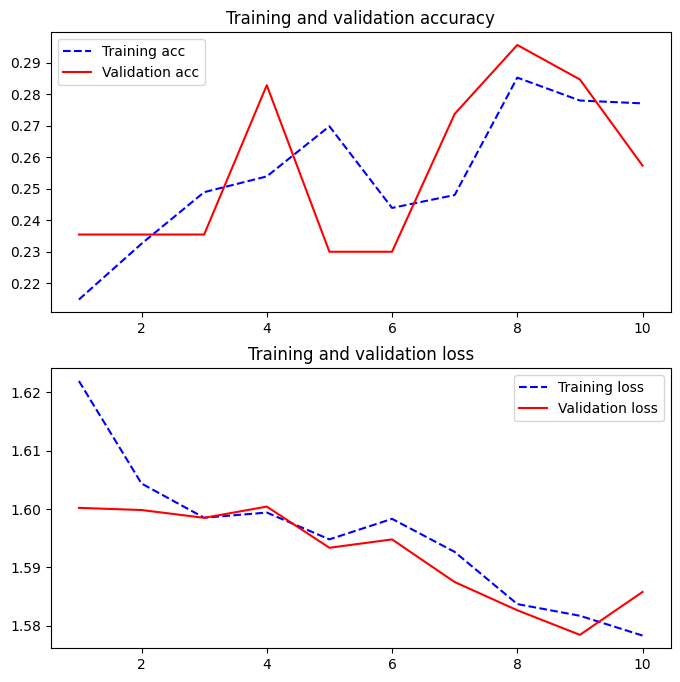

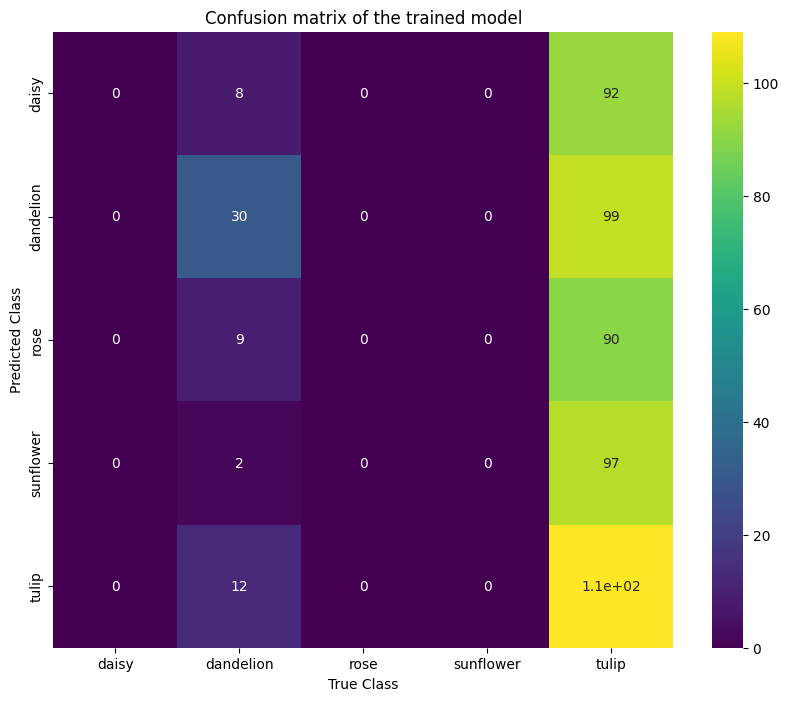

In [31]:
from tensorflow.keras.applications import EfficientNetV2B0

base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

eff_net_model, eff_net_loss, eff_net_acc, eff_net_conf_mtx = finetune_and_evaluate_pretrained_model(
    pretrained_model=base_model, 
    input_shape=(224, 224, 3), 
    train_generator=train_generator, 
    validation_generator=validation_generator, 
    early_stopping_patience=EARLY_STOPPING_PATIENCE, 
    epochs=EPOCHS
    )

## VGG16

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_8   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_16 (Dense)            (None, 128)               65664     
                                                                 
 dropout_8 (Dropout)         (None, 128)               0         
                                                                 
 dense_17 (Dense)            (None, 5)                 645       
                                                           

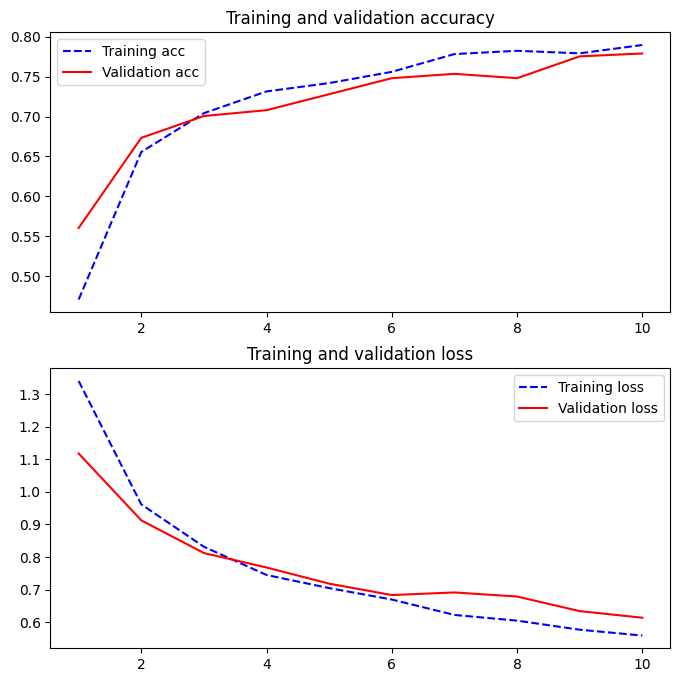

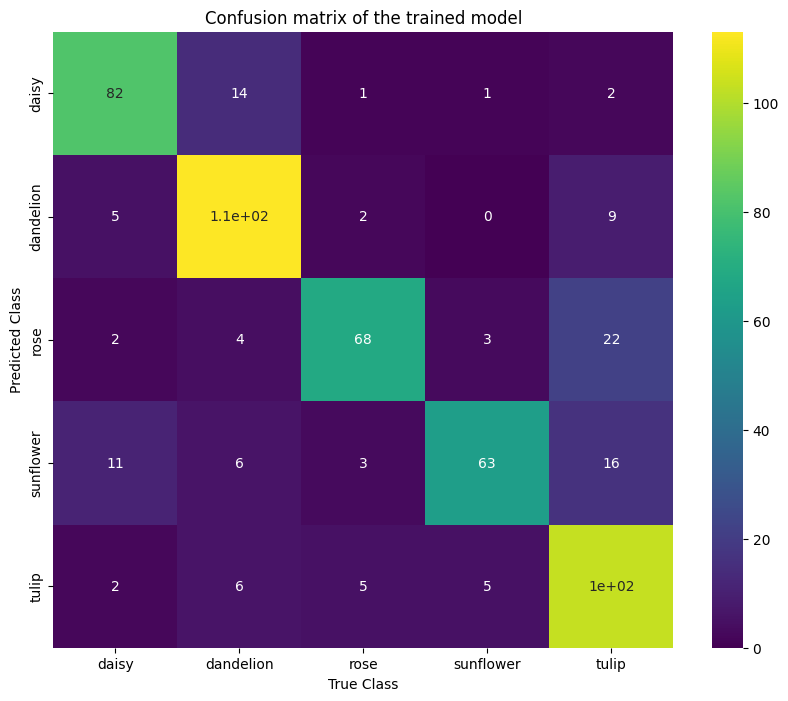

In [32]:
from keras.applications import VGG16

# Load the pre-trained VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

vgg_model, vgg_loss, vgg_acc, vgg_conf_mtx = finetune_and_evaluate_pretrained_model(
    pretrained_model=base_model, 
    input_shape=(224, 224, 3), 
    train_generator=train_generator, 
    validation_generator=validation_generator, 
    early_stopping_patience=EARLY_STOPPING_PATIENCE, 
    epochs=EPOCHS
    )

## MobileNetV2

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_10  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_20 (Dense)            (None, 128)               163968    
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 5)                 645

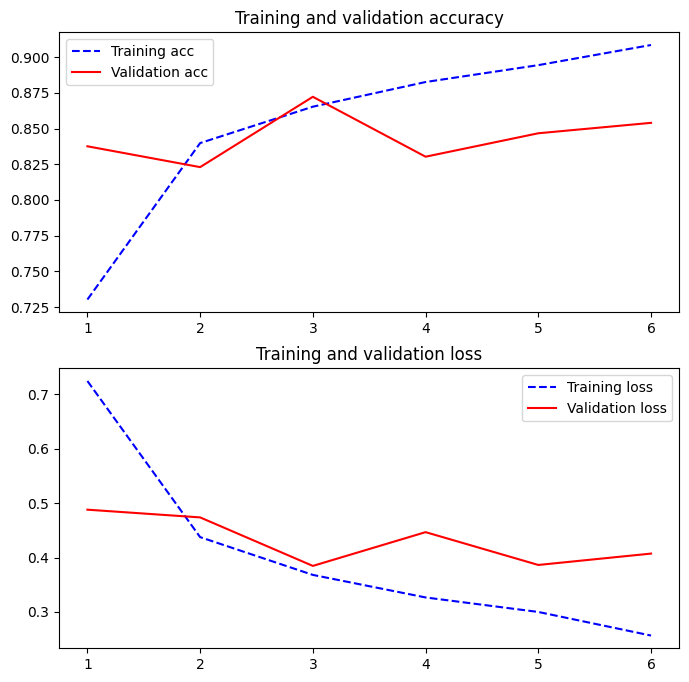

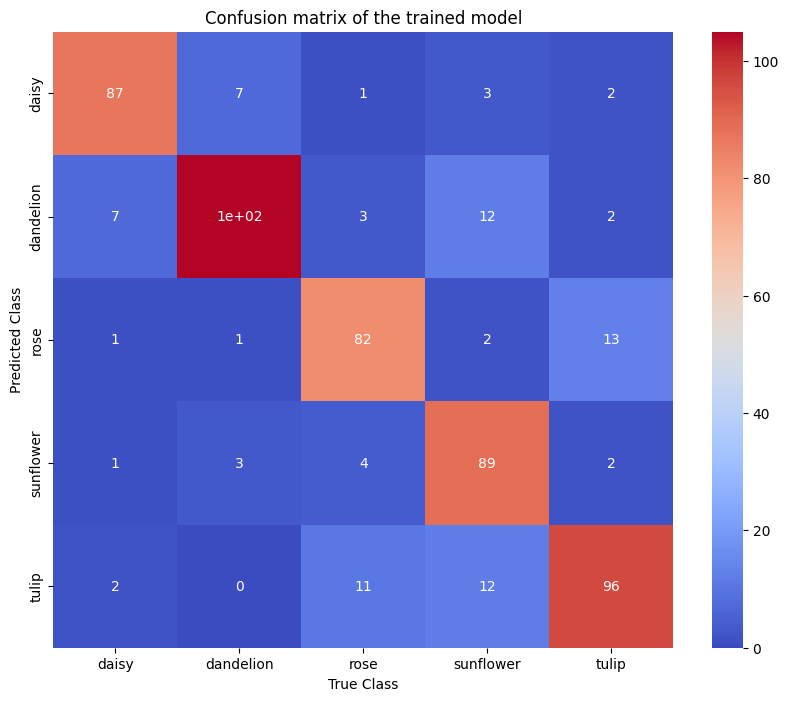

In [35]:
from tensorflow.keras.applications import MobileNetV2

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

mob_net_model, mob_net_loss, mob_net_acc, mob_net_conf_mtx = finetune_and_evaluate_pretrained_model(
    pretrained_model=base_model, 
    input_shape=(224, 224, 3), 
    train_generator=train_generator, 
    validation_generator=validation_generator, 
    early_stopping_patience=EARLY_STOPPING_PATIENCE, 
    epochs=EPOCHS
    )

## ResNet50

94765736/94765736 [==============================] - 133s 1us/step
Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_11  (None, 2048)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_22 (Dense)            (None, 128)               262272    
                                                                 
 dropout_11 (Dropout)        (None, 128)               0         
                                                                 
 dense_23 (Dense)            (None, 5)                 64

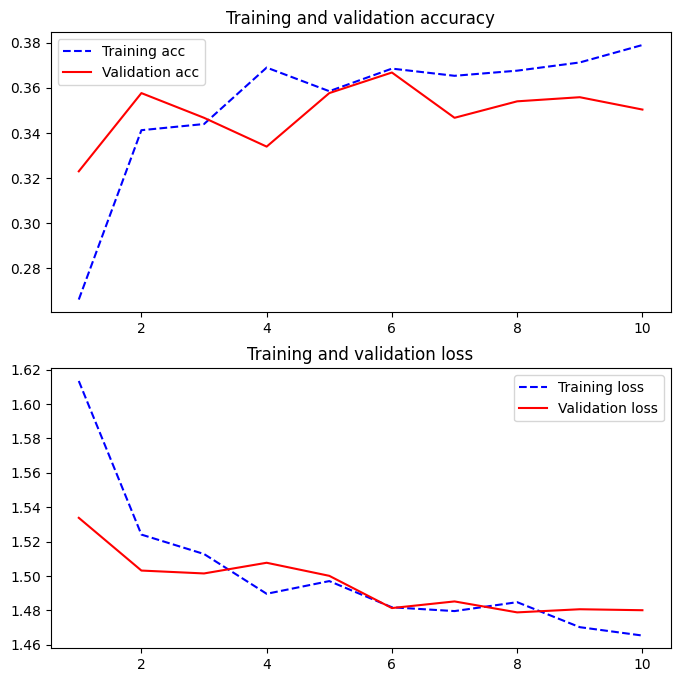

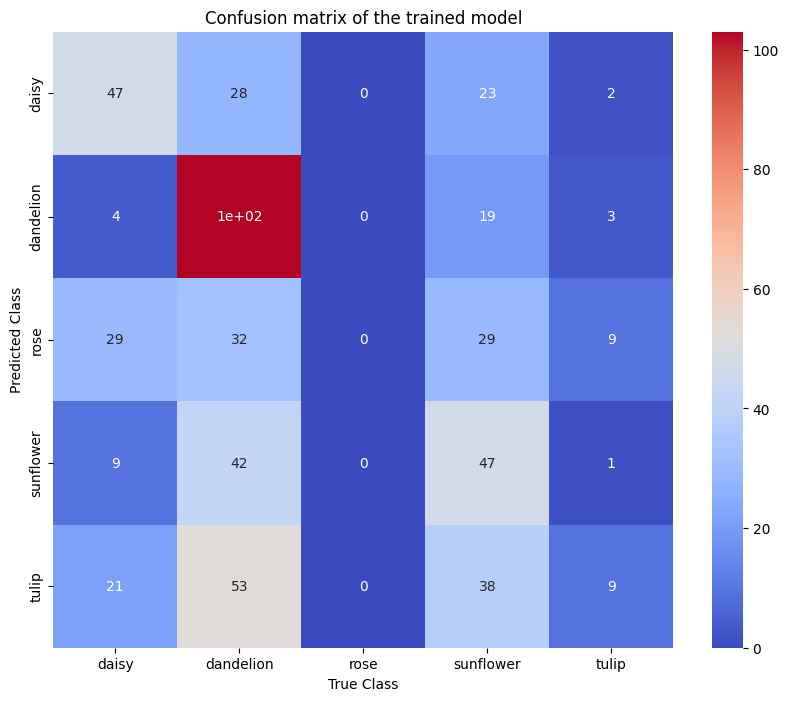

In [36]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

resnet_model, resnet_loss, resnet_acc, resnet_conf_mtx = finetune_and_evaluate_pretrained_model(
    pretrained_model=base_model, 
    input_shape=(224, 224, 3), 
    train_generator=train_generator, 
    validation_generator=validation_generator, 
    early_stopping_patience=EARLY_STOPPING_PATIENCE, 
    epochs=EPOCHS
    )

# MobileNetV2
- Finetune with higher number of epochs and higher patiences

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

mob_net_model, mob_net_loss, mob_net_acc, mob_net_conf_mtx = finetune_and_evaluate_pretrained_model(
    pretrained_model=base_model, 
    input_shape=(224, 224, 3), 
    train_generator=train_generator, 
    validation_generator=validation_generator, 
    early_stopping_patience=5, 
    epochs=20
    )

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_38 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_17  (None, 1280)             0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dense_34 (Dense)            (None, 128)               163968    
                                                                 
 dropout_17 (Dropout)        (None, 128)               0         
                                                                 
 dense_35 (Dense)            (None, 5)                 645

Text(0.5, 58.7222222222222, 'True Class')

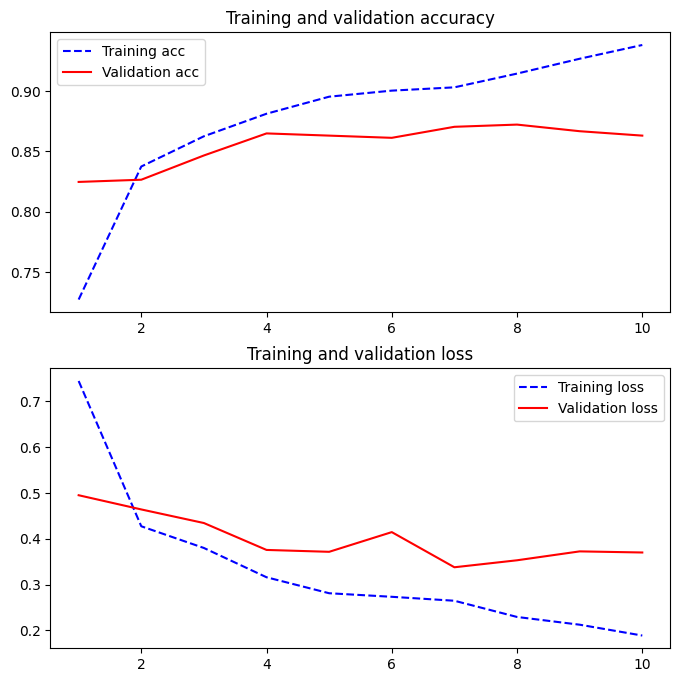

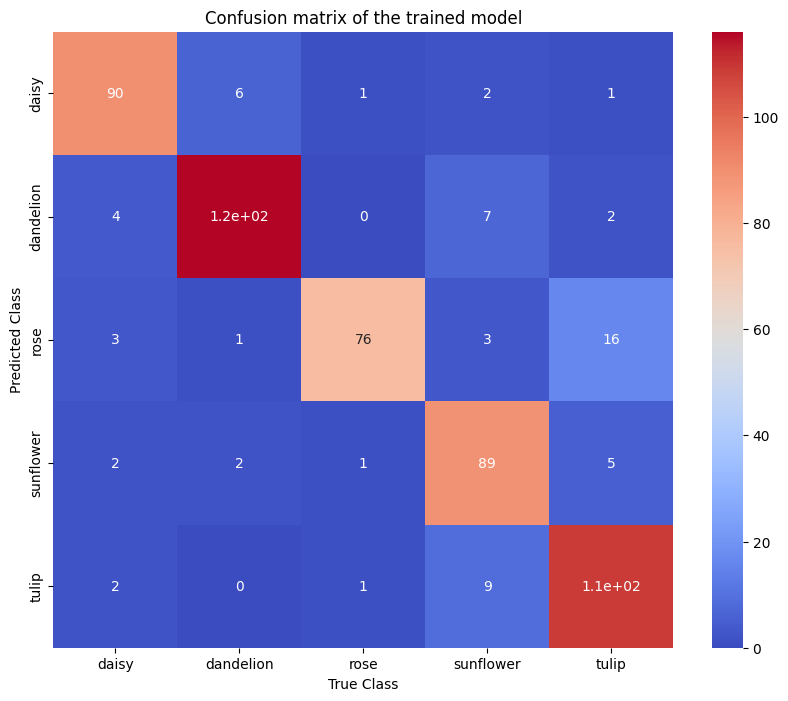

In [47]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(train_generator.num_classes, activation='softmax')(x)
custom_model = models.Model(inputs, x)
custom_model.summary()

custom_model.compile(loss='categorical_crossentropy',
                     optimizer='adam',
                     metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3, 
                               restore_best_weights=True)

history = custom_model.fit(train_generator, 
                            validation_data=validation_generator,
                            epochs=20,
                            callbacks=[early_stopping])

#Plot loss and accuracy curves
fig, ax = plt.subplots(2, 1, figsize = (8, 8))

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(acc) + 1)

ax[0].plot(epochs, acc, 'b--', label='Training acc')
ax[0].plot(epochs, val_acc, 'r', label='Validation acc')
ax[0].set_title('Training and validation accuracy')
ax[0].legend()

loss = history.history['loss']
val_loss = history.history['val_loss']
ax[1].plot(epochs, loss, 'b--', label='Training loss')
ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
ax[1].set_title('Training and validation loss')
ax[1].legend()

# Evaluation
loss, accuracy = custom_model.evaluate(validation_generator)
print(f'The accuracy of the model is: {accuracy*100:.2f}%')
print(f'The loss of the model is: {loss:.4f}')

# Prediction
pred = custom_model.predict(validation_generator)
y_test = validation_generator.classes
y_pred = np.argmax(pred, axis=1)

# Plot Confusion matrix
labels = [key for key in train_generator.class_indices.keys()]
cnf_mtx = confusion_matrix(y_test,y_pred)
plt.figure(figsize = (10,8))
sns.heatmap(cnf_mtx,
            annot=True, 
            xticklabels=labels,
            yticklabels=labels,
            cmap='coolwarm')
plt.title('Confusion matrix of the trained model')
plt.ylabel('Predicted Class')
plt.xlabel('True Class')

## Further Finetuning
- Unfreeze some base mode layers and continue fine-tuning

In [48]:
# Unfreeze the last few layers of the base model
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Compile again with a lower learning rate for fine-tuning
custom_model.compile(optimizer=optimizers.Adam(),
                     loss='categorical_crossentropy',
                     metrics=['accuracy'])

history_finetune = custom_model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/10
69/69 [==============================] - 49s 657ms/step - loss: 0.5175 - accuracy: 0.8176 - val_loss: 4.4114 - val_accuracy: 0.5931
Epoch 2/10
69/69 [==============================] - 46s 663ms/step - loss: 0.3463 - accuracy: 0.8781 - val_loss: 8.3567 - val_accuracy: 0.4708
Epoch 3/10
69/69 [==============================] - 47s 676ms/step - loss: 0.2492 - accuracy: 0.9195 - val_loss: 5.3300 - val_accuracy: 0.6515
Epoch 4/10
69/69 [==============================] - 48s 694ms/step - loss: 0.1883 - accuracy: 0.9390 - val_loss: 8.4794 - val_accuracy: 0.6478


# Testing

In [5]:
# Load the pre-trained EfficientNetV2B0 model without the top classification layer
base_model = EfficientNetV2B0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(train_generator.num_classes, activation='softmax')(x)

# Create the model
model = models.Model(inputs, outputs)

# Compile the model
model.compile(optimizer=optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model
model.summary()

24274472/24274472 [==============================] - 3s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Function  (None, 7, 7, 1280)       5919312   
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                              

In [6]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator,
    epochs=5,
    validation_data=validation_generator,
    callbacks=[early_stopping]
)

Epoch 1/5
69/69 [==============================] - 58s 743ms/step - loss: 1.6255 - accuracy: 0.2207 - val_loss: 1.6205 - val_accuracy: 0.1807
Epoch 2/5
69/69 [==============================] - 49s 702ms/step - loss: 1.6063 - accuracy: 0.2129 - val_loss: 1.6051 - val_accuracy: 0.2354
Epoch 3/5
69/69 [==============================] - 49s 713ms/step - loss: 1.6035 - accuracy: 0.2288 - val_loss: 1.6024 - val_accuracy: 0.2354
Epoch 4/5
69/69 [==============================] - 47s 683ms/step - loss: 1.6053 - accuracy: 0.2425 - val_loss: 1.6013 - val_accuracy: 0.2354
Epoch 5/5
69/69 [==============================] - 49s 703ms/step - loss: 1.6011 - accuracy: 0.2375 - val_loss: 1.6000 - val_accuracy: 0.2354


In [7]:
loss, accuracy = model.evaluate(validation_generator)

18/18 [==============================] - 9s 503ms/step - loss: 1.6000 - accuracy: 0.2354


In [8]:
loss

1.6000338792800903

In [9]:
accuracy

0.2354014664888382